In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0" 
import torch
torch.cuda.device_count()

1

In [3]:
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from glob import glob
# import wandb

import monai
from monai.losses import DiceCELoss, DiceFocalLoss, FocalLoss
from monai.inferers import sliding_window_inference
from monai import transforms

from monai.transforms import (
    AsDiscrete,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
    MapTransform,
    ScaleIntensityd,
    #AddChanneld,
    SpatialPadd,
    CenterSpatialCropd,
    EnsureChannelFirstd,
    ConcatItemsd,
    AdjustContrastd, 
    Rand3DElasticd,
    HistogramNormalized,
    NormalizeIntensityd,
    Invertd,
    SaveImage,

)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.networks.nets import SwinUNETR, UNETR, SegResNet

from monai.data import (
    DataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
)
from monai import data


from monai.utils import first, set_determinism
from sklearn.model_selection import train_test_split
import json


import torch

In [4]:
set_determinism(seed=1024)


In [ ]:
# import json
# import os
# import random

# centers = ['CHUM', 'CHUP', 'CHUS', 'CHUV', 'HGJ', 'HMR', 'MDA']
# base_dir = '/home/nada.saadi/MIS-FM/hecktor2022_cropped'
# num_folds = 4

# # Function to generate file paths for a patient
# def generate_paths(center, patient_id):
#     return {
#         'id': os.path.join(base_dir, center, patient_id),
#         'ct': os.path.join(base_dir, center, patient_id, f"{patient_id}_ct.nii.gz"),
#         'pt': os.path.join(base_dir, center, patient_id, f"{patient_id}_pt.nii.gz"),
#         'seg': os.path.join(base_dir, center, patient_id, f"{patient_id}_gt.nii.gz")
#     }

# # Gather all data entries
# all_data = []
# for center in centers:
#     # Replace this with actual method to list patient IDs in each center
#     patient_ids = os.listdir(os.path.join(base_dir, center))
#     for patient_id in patient_ids:
#         all_data.append(generate_paths(center, patient_id))

# # Randomly assign data to folds
# for entry in all_data:
#     entry['fold'] = random.randint(1, num_folds)

# # Wrap data in a parent dictionary under the "training" key
# data_json = {"training": all_data}

# # Save to JSON file
# json_file_path = "/home/nada.saadi/MIS-FM/hecktor2022_cropped/train_json_new.json"
# with open(json_file_path, "w") as f:
#     json.dump(data_json, f, indent=4)

# print(f"JSON file created at {json_file_path}")


In [ ]:
import os
import json
import random

def generate_paths(patient_id):
    base_dir = '/home/nada.saadi/MIS-FM/hecktor2022_cropped/data'
    return {
        'id': os.path.join(base_dir, patient_id),
        'ct': os.path.join(base_dir, patient_id, f"{patient_id}_ct.nii.gz"),
        'pt': os.path.join(base_dir, patient_id, f"{patient_id}_pt.nii.gz"),
        'seg': os.path.join(base_dir, patient_id, f"{patient_id}_gt.nii.gz")
    }



# Assign each data entry to a random fold
all_data = []
num_folds = 5
for file_dir in sorted(glob('data/*')):
    patient_id = file_dir.split('/')[-1]
    entry = generate_paths(patient_id)
    entry['fold'] = random.randint(1, num_folds) - 1
    all_data.append(entry)

# Compile data into a JSON structure
data_json = {"training": all_data}

# # Save to JSON file
json_file_path = "/home/nada.saadi/MIS-FM/hecktor2022_cropped/train_json_new.json"
with open(json_file_path, 'w') as f:
    json.dump(data_json, f, indent=4)

print(f"JSON file created at {json_file_path}")



In [ ]:
# import json
# import os
# import random

# # Assuming the 'patient_ids' list contains all the patient IDs from different centers
# random.shuffle(patient_ids)

# # Split into training and validation sets (80% training, 20% validation)
# # Total files = 419 (training) + 105 (validation)
# num_training = 419
# num_validation = 105
# train_patient_ids = patient_ids[:num_training]
# val_patient_ids = patient_ids[num_training:num_training + num_validation]

# # Generate dictionaries for training and validation
# train_dicts = []
# val_dicts = []

# for pid in train_patient_ids:
#     train_dicts.append({
#         'id': f"/home/nada.saadi/MIS-FM/hecktor2022_cropped/{pid}",
#         'fold': random.randint(0, 3),  # Random fold assignment
#         'ct': f"/home/nada.saadi/MIS-FM/hecktor2022_cropped/{pid}/{pid}_ct.nii.gz",
#         'pt': f"/home/nada.saadi/MIS-FM/hecktor2022_cropped/{pid}/{pid}_pt.nii.gz",
#         'seg': f"/home/nada.saadi/MIS-FM/hecktor2022_cropped/{pid}/{pid}_gt.nii.gz"
#     })

# for pid in val_patient_ids:
#     val_dicts.append({
#         'id': f"/home/nada.saadi/MIS-FM/hecktor2022_cropped/{pid}",
#         'fold': random.randint(0, 3),  # Random fold assignment
#         'ct': f"/home/nada.saadi/MIS-FM/hecktor2022_cropped/{pid}/{pid}_ct.nii.gz",
#         'pt': f"/home/nada.saadi/MIS-FM/hecktor2022_cropped/{pid}/{pid}_pt.nii.gz",
#         'seg': f"/home/nada.saadi/MIS-FM/hecktor2022_cropped/{pid}/{pid}_gt.nii.gz"
#     })

# # Creating JSON data structure
# json_data = {
#     "training": train_dicts,
#     "validation": val_dicts
# }

# # Save as JSON file
# json_file_path = "/home/nada.saadi/MIS-FM/hecktor2022_cropped/train_val_json_new.json"
# with open(json_file_path, 'w') as f:
#     json.dump(json_data, f, indent=4)

# # Outputting the path of the JSON file
# json_file_path



In [7]:
data_dir = '/home/nada.saadi/MIS-FM/hecktor2022_cropped'
json_dir = '/home/nada.saadi/MIS-FM/hecktor2022_cropped/train_json_new.json'

In [5]:
def datafold_read(datalist, basedir, fold=0, key="training"):
    with open(datalist) as f:
        json_data = json.load(f)

    json_data = json_data[key]

    for d in json_data:
        for k in d:
            if isinstance(d[k], list):
                d[k] = [os.path.join(basedir, iv) for iv in d[k]]
            elif isinstance(d[k], str):
                d[k] = os.path.join(basedir, d[k]) if len(d[k]) > 0 else d[k]

    tr = []
    val = []
    for d in json_data:
        if "fold" in d and d["fold"] == fold:
            val.append(d)
        else:
            tr.append(d)

    return tr, val

In [8]:
train_files, validation_files = datafold_read(datalist=json_dir, basedir=data_dir, fold=0)
len(train_files), len(validation_files)

(406, 114)

torch.Size([200, 200, 310])


/home/nada.saadi/miniconda3/envs/clam/lib/python3.8/site-packages/monai/transforms/spatial/array.py:635: UserWarning: axcodes ('RAS') length is smaller than number of input spatial dimensions D=2.
Orientation: spatial shape = (200, 310), channels = 200,please make sure the input is in the channel-first format.
  warnings.warn(


NameError: name 'contours' is not defined

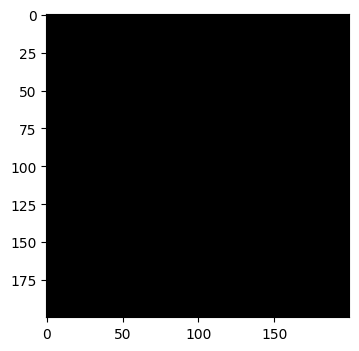

In [9]:
from skimage import measure

slice_num = 150
gt = monai.transforms.LoadImage(ensure_channel_first=True)('data/CHUS-081/CHUS-081_gt.nii.gz')
plt.figure("image", (18, 10))
gt = monai.transforms.Orientation(axcodes='RAS')(gt[0])
plt.subplot(2, 4, 1)
plt.imshow(gt[:,:,slice_num], cmap='gray')
print(gt.shape)

# contours = measure.find_contours(gt[:,slice_num,:], 0.5)[0]
plt.plot(contours[:, 1], contours[:, 0], linewidth=0.8, c='red',  alpha = 0.8)

ct = monai.transforms.LoadImage(ensure_channel_first=True)('data/CHUV-002/CHUV-002_ct.nii.gz')
ct = monai.transforms.Orientation(axcodes='RAS')(ct[0])
ct = torch.clip(ct, min=-1000, max=600)
plt.subplot(2, 4, 2)
plt.imshow(ct[:,:,slice_num], cmap='gray')
plt.plot(contours[:, 1], contours[:, 0], linewidth=0.8, c='red',  alpha = 0.8)

pt = monai.transforms.LoadImage(ensure_channel_first=True)('data/CHUV-002/CHUV-002_pt.nii.gz')
pt = monai.transforms.Orientation(axcodes='RAS')(pt[0])
plt.subplot(2, 4, 3)
plt.imshow(pt[:,:,slice_num], cmap='gray')
plt.plot(contours[:, 1], contours[:, 0], linewidth=0.8, c='red',  alpha = 0.8)

In [10]:
class ClipCT(MapTransform):
    """
    Convert labels to multi channels based on hecktor classes:
    label 1 is the tumor
    label 2 is the lymph node

    """

    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            if key == "ct":
                d[key] = torch.clip(d[key], min=-200, max=200)
            # elif key == "pt":
            #     d[key] = torch.clip(d[key], d[key].min(), 5)
        return d

class MulPTFM(MapTransform):
    """
    Mult PT and FM 

    """

    def __call__(self, data):
        d = dict(data)

        fm = d["ct"] > 0
        d["pt"] = d["pt"] * fm
        return d

class SelectClass(MapTransform):
    """
    Select the class for which you want to fine tune the model 

    """
    # def __init__(self, keys, cls=1):
    #     super(self).__init__(keys)
    #     self.cls = cls

    def __call__(self, data):
        d = dict(data)
        d["seg"][d["seg"] == 1] = 0
        # d["seg"][d["seg"] == 2] = 1
        
        return d

In [11]:
num_samples = 4

train_transforms = Compose(
    [
        LoadImaged(keys=["ct", "pt", "seg"], ensure_channel_first = True),
        SpatialPadd(keys=["ct", "pt", "seg"], spatial_size=(200, 200, 310), method='end'),
        Orientationd(keys=["ct", "pt", "seg"], axcodes="PLS"),
        NormalizeIntensityd(keys=["pt"]),
        ClipCT(keys=["ct"]),
        ScaleIntensityd(keys=["ct"], minv=0, maxv=1),
        #MulPTFM(keys=["ct","pt"]),
        ConcatItemsd(keys=["pt", "ct"], name="ctpt"),
        #NormalizeIntensityd(keys=["ctpt"], channel_wise=True),
        RandCropByPosNegLabeld(
            keys=["ctpt", "seg"],
            label_key="seg",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=num_samples,
            image_key="ctpt",
            image_threshold=0,
        ),
        RandFlipd(
            keys=["ctpt", "seg"],
            spatial_axis=[0],
            prob=0.20,
        ),
        RandFlipd(
            keys=["ctpt", "seg"],
            spatial_axis=[1],
            prob=0.20,
        ),
        RandFlipd(
            keys=["ctpt", "seg"],
            spatial_axis=[2],
            prob=0.20,
        ),
        RandRotate90d(
            keys=["ctpt", "seg"],
            prob=0.20,
            max_k=3,
        ),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["ct", "pt", "seg"], ensure_channel_first = True),
        SpatialPadd(keys=["ct", "pt", "seg"], spatial_size=(200, 200, 310), method='end'),
        Orientationd(keys=["ct", "pt", "seg"], axcodes="PLS"),
        NormalizeIntensityd(keys=["pt"]),
        ClipCT(keys=["ct"]),
        ScaleIntensityd(keys=["ct"], minv=0, maxv=1),
        #MulPTFM(keys=["ct","pt"]),
        ConcatItemsd(keys=["pt", "ct"], name="ctpt"),
    ]
)

In [12]:
train_ds = monai.data.Dataset(data=train_files, transform=train_transforms)

train_loader = DataLoader(
    train_ds,
    batch_size=2,
    shuffle=True,
    num_workers=8,
    pin_memory=torch.cuda.is_available(),
    )

val_ds = monai.data.Dataset(data=validation_files, transform=val_transforms)

val_loader = DataLoader(
    val_ds, 
    batch_size=2, 
    num_workers=8, 
    shuffle= False)

In [ ]:
a = next(iter(train_loader))

In [ ]:
a['ct'].shape

In [13]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# model = SegResNet(in_channels=2, 
#                   out_channels=3, 
#                   init_filters=16).to(device)

# model = UNETR(
#     in_channels=2,
#     out_channels=3,
#     img_size=(96, 96, 96),
#     feature_size=16,
#     hidden_size=768,
#     mlp_dim=3072,
#     num_heads=12,
#     pos_embed="perceptron",
#     norm_name="instance",
#     res_block=True,
#     dropout_rate=0.0,
# ).to(device)

model = SwinUNETR(img_size= (96, 96, 96),
                  in_channels=2,
                  out_channels=3,
                  depths = (2, 2, 2, 2),
                  num_heads = (3, 6, 12, 24),
                  feature_size = 24,
                  norm_name = "instance",
                  drop_rate = 0.0,
                attn_drop_rate = 0.0,
                dropout_path_rate = 0.0,
                normalize = True,
                use_checkpoint = False,
                spatial_dims = 3,
                downsample="merging").to(device)

In [14]:
torch.backends.cudnn.benchmark = True
def poly_lr(epoch, max_epochs, initial_lr, exponent=0.9):
    return initial_lr * (1 - epoch / max_epochs)**exponent

loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

In [12]:
model_dir = '/home/nada.saadi/MIS-FM/hecktor2022_cropped/files'

def validation(epoch_iterator_val):
    model.eval()
    with torch.no_grad():
        for step, batch in enumerate(epoch_iterator_val):
            val_inputs, val_labels = (batch["ctpt"].cuda(), batch["seg"].cuda())
            val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [
                post_label(val_label_tensor) for val_label_tensor in val_labels_list
            ]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [
                post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list
            ]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            dice_metric_batch(y_pred=val_output_convert, y=val_labels_convert)
            epoch_iterator_val.set_description(
                "Validate (%d / %d Steps)" % (global_step, 10.0)
            )
        mean_dice_val = dice_metric.aggregate().item()
        metric_batch_val = dice_metric_batch.aggregate()

        metric_tumor = metric_batch_val[0].item()
        metric_lymph = metric_batch_val[1].item()

        dice_metric.reset()
        dice_metric_batch.reset()
    return mean_dice_val, metric_tumor, metric_lymph


def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(
        train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True
    )
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["ctpt"].cuda(), batch["seg"].cuda())
        logit_map = model(x)
        loss = loss_function(logit_map, y)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()
        epoch_iterator.set_description(
            "Training (%d / %d Steps) (loss=%2.5f)"
            % (global_step, max_iterations, loss)
        )
        if (
            global_step % eval_num == 0 and global_step != 0
        ) or global_step == max_iterations:
            epoch_iterator_val = tqdm(
                val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True
            )
            dice_val, metric_tumor, metric_lymph = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            metric_values_tumor.append(metric_tumor)
            metric_values_lymph.append(metric_lymph)
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(
                    model.state_dict(), os.path.join(model_dir, "best_metric_segresnet.pth")
                )
                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {} Current Avg. tumor Dice: {} Current Avg. lymph Dice: {}".format(
                        dice_val_best, dice_val, metric_tumor, metric_lymph
                    )
                )
            else:
                print(
                    "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {} Current Avg. tumor Dice: {} Current Avg. lymph Dice: {}".format(
                        dice_val_best, dice_val,  metric_tumor, metric_lymph
                    )
                )
        global_step += 1
    return global_step, dice_val_best, global_step_best


max_iterations = 18000
eval_num = 100

post_label = AsDiscrete(to_onehot=3)
post_pred = AsDiscrete(argmax=True, to_onehot=3)

dice_metric = DiceMetric(include_background=False, reduction="mean", get_not_nans=False)
dice_metric_batch = DiceMetric(include_background=False, reduction="mean_batch")

epoch = 0
max_num_epochs = 530

global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []
metric_values_tumor = []
metric_values_lymph = []
while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(
        global_step, train_loader, dice_val_best, global_step_best
    )
    # wandb.log({'learning_rate': optimizer.param_groups[0]['lr']})
    # wandb.log({'Best Dice': dice_val_best})
    epoch += 1
    #optimizer.param_groups[0]['lr'] = poly_lr(epoch, max_num_epochs, 0.005676 , 0.9)
# model.load_state_dict(torch.load(os.path.join(model_dir, "best_metric_luck_UNETr_prompt.pth")))

Training (100 / 18000 Steps) (loss=1.52619):  50%|████▉     | 101/203 [05:54<1:41:47, 59.87s/it]

Model Was Saved ! Current Best Avg. Dice: 0.05297548696398735 Current Avg. Dice: 0.05297548696398735 Current Avg. tumor Dice: 0.09277383238077164 Current Avg. lymph Dice: 0.006442411802709103


Training (200 / 18000 Steps) (loss=1.40533):  99%|█████████▉| 201/203 [10:52<01:57, 58.77s/it]

Model Was Saved ! Current Best Avg. Dice: 0.14792869985103607 Current Avg. Dice: 0.14792869985103607 Current Avg. tumor Dice: 0.23086318373680115 Current Avg. lymph Dice: 0.05085344985127449


Training (300 / 18000 Steps) (loss=1.25345):  48%|████▊     | 98/203 [05:05<1:43:17, 59.02s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.14792869985103607 Current Avg. Dice: 0.14455324411392212 Current Avg. tumor Dice: 0.21939213573932648 Current Avg. lymph Dice: 0.056962914764881134


Training (400 / 18000 Steps) (loss=1.17415):  98%|█████████▊| 198/203 [10:01<04:52, 58.42s/it]

Model Was Saved ! Current Best Avg. Dice: 0.2699584364891052 Current Avg. Dice: 0.2699584364891052 Current Avg. tumor Dice: 0.45151907205581665 Current Avg. lymph Dice: 0.034147489815950394


Training (500 / 18000 Steps) (loss=1.07734):  47%|████▋     | 95/203 [04:58<1:45:39, 58.70s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.2699584364891052 Current Avg. Dice: 0.26330509781837463 Current Avg. tumor Dice: 0.43402132391929626 Current Avg. lymph Dice: 0.04127592220902443


Training (600 / 18000 Steps) (loss=1.00083):  96%|█████████▌| 195/203 [09:54<07:45, 58.17s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.2699584364891052 Current Avg. Dice: 0.2284862995147705 Current Avg. tumor Dice: 0.3708886504173279 Current Avg. lymph Dice: 0.058748845010995865


Training (700 / 18000 Steps) (loss=0.93874):  45%|████▌     | 92/203 [04:52<1:47:26, 58.07s/it]

Model Was Saved ! Current Best Avg. Dice: 0.3219890296459198 Current Avg. Dice: 0.3219890296459198 Current Avg. tumor Dice: 0.28675955533981323 Current Avg. lymph Dice: 0.36641284823417664


Training (800 / 18000 Steps) (loss=0.92401):  95%|█████████▍| 192/203 [09:48<10:40, 58.21s/it]

Model Was Saved ! Current Best Avg. Dice: 0.4027658998966217 Current Avg. Dice: 0.4027658998966217 Current Avg. tumor Dice: 0.5024153590202332 Current Avg. lymph Dice: 0.27515357732772827


Training (900 / 18000 Steps) (loss=0.86997):  44%|████▍     | 89/203 [04:52<1:51:21, 58.61s/it]

Model Was Saved ! Current Best Avg. Dice: 0.48399046063423157 Current Avg. Dice: 0.48399046063423157 Current Avg. tumor Dice: 0.556064248085022 Current Avg. lymph Dice: 0.3914124667644501


Training (1000 / 18000 Steps) (loss=0.76825):  93%|█████████▎| 189/203 [09:48<13:35, 58.27s/it]

Model Was Saved ! Current Best Avg. Dice: 0.5542746186256409 Current Avg. Dice: 0.5542746186256409 Current Avg. tumor Dice: 0.6085955500602722 Current Avg. lymph Dice: 0.481467068195343


Training (1100 / 18000 Steps) (loss=0.71547):  42%|████▏     | 86/203 [04:50<1:54:23, 58.66s/it]

Model Was Saved ! Current Best Avg. Dice: 0.5638982057571411 Current Avg. Dice: 0.5638982057571411 Current Avg. tumor Dice: 0.6190581917762756 Current Avg. lymph Dice: 0.4936155378818512


Training (1200 / 18000 Steps) (loss=0.72550):  92%|█████████▏| 186/203 [09:50<16:45, 59.14s/it]

Model Was Saved ! Current Best Avg. Dice: 0.5646663308143616 Current Avg. Dice: 0.5646663308143616 Current Avg. tumor Dice: 0.6184021234512329 Current Avg. lymph Dice: 0.4966476559638977


Training (1300 / 18000 Steps) (loss=0.72013):  41%|████      | 83/203 [04:46<1:57:28, 58.73s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5646663308143616 Current Avg. Dice: 0.5342403054237366 Current Avg. tumor Dice: 0.5890415906906128 Current Avg. lymph Dice: 0.46939414739608765


Training (1400 / 18000 Steps) (loss=0.58879):  90%|█████████ | 183/203 [09:43<19:29, 58.48s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5646663308143616 Current Avg. Dice: 0.5329936742782593 Current Avg. tumor Dice: 0.6140294671058655 Current Avg. lymph Dice: 0.43378525972366333


Training (1500 / 18000 Steps) (loss=0.66889):  39%|███▉      | 80/203 [04:41<2:00:06, 58.59s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5646663308143616 Current Avg. Dice: 0.5617441534996033 Current Avg. tumor Dice: 0.6306203007698059 Current Avg. lymph Dice: 0.4796445369720459


Training (1600 / 18000 Steps) (loss=0.58784):  89%|████████▊ | 180/203 [09:39<22:28, 58.61s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5646663308143616 Current Avg. Dice: 0.5546903610229492 Current Avg. tumor Dice: 0.6210262179374695 Current Avg. lymph Dice: 0.4734106659889221


Training (1700 / 18000 Steps) (loss=0.60542):  38%|███▊      | 77/203 [04:40<2:03:10, 58.66s/it]

Model Was Saved ! Current Best Avg. Dice: 0.5862458944320679 Current Avg. Dice: 0.5862458944320679 Current Avg. tumor Dice: 0.6465173959732056 Current Avg. lymph Dice: 0.5123716592788696


Training (1800 / 18000 Steps) (loss=0.60840):  87%|████████▋ | 177/203 [09:38<25:28, 58.80s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5862458944320679 Current Avg. Dice: 0.5586296916007996 Current Avg. tumor Dice: 0.6392644643783569 Current Avg. lymph Dice: 0.4612277150154114


Training (1900 / 18000 Steps) (loss=0.66957):  36%|███▋      | 74/203 [04:38<2:05:42, 58.47s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5862458944320679 Current Avg. Dice: 0.5802678465843201 Current Avg. tumor Dice: 0.6337890028953552 Current Avg. lymph Dice: 0.5158212184906006


Training (2000 / 18000 Steps) (loss=0.53645):  86%|████████▌ | 174/203 [09:35<28:14, 58.42s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5862458944320679 Current Avg. Dice: 0.5755308270454407 Current Avg. tumor Dice: 0.6137877106666565 Current Avg. lymph Dice: 0.5272276401519775


Training (2100 / 18000 Steps) (loss=0.48300):  35%|███▍      | 71/203 [04:32<2:08:51, 58.57s/it]

Model Was Saved ! Current Best Avg. Dice: 0.5885420441627502 Current Avg. Dice: 0.5885420441627502 Current Avg. tumor Dice: 0.6652652025222778 Current Avg. lymph Dice: 0.49303099513053894


Training (2200 / 18000 Steps) (loss=0.45125):  84%|████████▍ | 171/203 [09:30<31:21, 58.79s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5885420441627502 Current Avg. Dice: 0.555640697479248 Current Avg. tumor Dice: 0.5884593725204468 Current Avg. lymph Dice: 0.5132631063461304


Training (2300 / 18000 Steps) (loss=0.56461):  33%|███▎      | 68/203 [04:31<2:11:38, 58.51s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5885420441627502 Current Avg. Dice: 0.5708248019218445 Current Avg. tumor Dice: 0.615359902381897 Current Avg. lymph Dice: 0.511838436126709


Training (2400 / 18000 Steps) (loss=0.55087):  83%|████████▎ | 168/203 [09:28<34:03, 58.39s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5885420441627502 Current Avg. Dice: 0.5612086057662964 Current Avg. tumor Dice: 0.5935654044151306 Current Avg. lymph Dice: 0.5240438580513


Training (2500 / 18000 Steps) (loss=0.60863):  32%|███▏      | 65/203 [04:28<2:15:09, 58.77s/it]

Model Was Saved ! Current Best Avg. Dice: 0.5998719930648804 Current Avg. Dice: 0.5998719930648804 Current Avg. tumor Dice: 0.6631426215171814 Current Avg. lymph Dice: 0.5217664241790771


Training (2600 / 18000 Steps) (loss=0.54585):  81%|████████▏ | 165/203 [09:25<37:04, 58.54s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5998719930648804 Current Avg. Dice: 0.5628031492233276 Current Avg. tumor Dice: 0.5959635972976685 Current Avg. lymph Dice: 0.5183991193771362


Training (2700 / 18000 Steps) (loss=0.49716):  31%|███       | 62/203 [04:24<2:17:22, 58.45s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5998719930648804 Current Avg. Dice: 0.559380292892456 Current Avg. tumor Dice: 0.6165705919265747 Current Avg. lymph Dice: 0.49160078167915344


Training (2800 / 18000 Steps) (loss=0.62364):  80%|███████▉  | 162/203 [09:22<40:06, 58.70s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5998719930648804 Current Avg. Dice: 0.5612391233444214 Current Avg. tumor Dice: 0.600019633769989 Current Avg. lymph Dice: 0.5186391472816467


Training (2900 / 18000 Steps) (loss=0.50020):  29%|██▉       | 59/203 [04:20<2:20:44, 58.64s/it]

Model Was Saved ! Current Best Avg. Dice: 0.6093531250953674 Current Avg. Dice: 0.6093531250953674 Current Avg. tumor Dice: 0.6636338829994202 Current Avg. lymph Dice: 0.5371297001838684


Training (3000 / 18000 Steps) (loss=0.56146):  78%|███████▊  | 159/203 [09:18<43:05, 58.75s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6093531250953674 Current Avg. Dice: 0.582304835319519 Current Avg. tumor Dice: 0.6144576668739319 Current Avg. lymph Dice: 0.5452500581741333


Training (3100 / 18000 Steps) (loss=0.50199):  28%|██▊       | 56/203 [04:17<2:23:35, 58.61s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6093531250953674 Current Avg. Dice: 0.6040804386138916 Current Avg. tumor Dice: 0.6646133065223694 Current Avg. lymph Dice: 0.5251843333244324


Training (3200 / 18000 Steps) (loss=0.53100):  77%|███████▋  | 156/203 [09:15<45:57, 58.66s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6093531250953674 Current Avg. Dice: 0.5266554355621338 Current Avg. tumor Dice: 0.6068665385246277 Current Avg. lymph Dice: 0.4288230538368225


Training (3300 / 18000 Steps) (loss=0.52865):  26%|██▌       | 53/203 [04:14<2:26:16, 58.51s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6093531250953674 Current Avg. Dice: 0.573667585849762 Current Avg. tumor Dice: 0.6158361434936523 Current Avg. lymph Dice: 0.5176302194595337


Training (3400 / 18000 Steps) (loss=0.50560):  75%|███████▌  | 153/203 [09:12<48:56, 58.73s/it]

Model Was Saved ! Current Best Avg. Dice: 0.6170880794525146 Current Avg. Dice: 0.6170880794525146 Current Avg. tumor Dice: 0.6743279099464417 Current Avg. lymph Dice: 0.5450094938278198


Training (3500 / 18000 Steps) (loss=0.43630):  25%|██▍       | 50/203 [04:10<2:29:28, 58.62s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6170880794525146 Current Avg. Dice: 0.5956923365592957 Current Avg. tumor Dice: 0.6633266806602478 Current Avg. lymph Dice: 0.5158820748329163


Training (3600 / 18000 Steps) (loss=0.40495):  74%|███████▍  | 150/203 [09:08<51:53, 58.75s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6170880794525146 Current Avg. Dice: 0.5972588658332825 Current Avg. tumor Dice: 0.6626406908035278 Current Avg. lymph Dice: 0.514225423336029


Training (3700 / 18000 Steps) (loss=0.43020):  23%|██▎       | 47/203 [04:06<2:31:37, 58.32s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6170880794525146 Current Avg. Dice: 0.6046266555786133 Current Avg. tumor Dice: 0.6638045310974121 Current Avg. lymph Dice: 0.5272790789604187


Training (3800 / 18000 Steps) (loss=0.56204):  72%|███████▏  | 147/203 [09:03<54:34, 58.47s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6170880794525146 Current Avg. Dice: 0.5868018865585327 Current Avg. tumor Dice: 0.6376156210899353 Current Avg. lymph Dice: 0.5220377445220947


Training (3900 / 18000 Steps) (loss=0.37917):  22%|██▏       | 44/203 [04:05<2:35:05, 58.53s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6170880794525146 Current Avg. Dice: 0.6084506511688232 Current Avg. tumor Dice: 0.6494865417480469 Current Avg. lymph Dice: 0.5561394095420837


Training (4000 / 18000 Steps) (loss=0.54429):  71%|███████   | 144/203 [09:02<57:39, 58.64s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6170880794525146 Current Avg. Dice: 0.6065406203269958 Current Avg. tumor Dice: 0.6560778021812439 Current Avg. lymph Dice: 0.5428970456123352


Training (4100 / 18000 Steps) (loss=0.47510):  20%|██        | 41/203 [03:58<2:36:27, 57.95s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6170880794525146 Current Avg. Dice: 0.6130236387252808 Current Avg. tumor Dice: 0.6673803925514221 Current Avg. lymph Dice: 0.5424284338951111


Training (4200 / 18000 Steps) (loss=0.53378):  69%|██████▉   | 141/203 [08:54<1:00:07, 58.18s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6170880794525146 Current Avg. Dice: 0.5961979627609253 Current Avg. tumor Dice: 0.6393596529960632 Current Avg. lymph Dice: 0.542798638343811


Training (4300 / 18000 Steps) (loss=0.45624):  19%|█▊        | 38/203 [03:56<2:40:26, 58.34s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6170880794525146 Current Avg. Dice: 0.6040639877319336 Current Avg. tumor Dice: 0.6669420599937439 Current Avg. lymph Dice: 0.5288209915161133


Training (4400 / 18000 Steps) (loss=0.40307):  68%|██████▊   | 138/203 [08:54<1:03:20, 58.47s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6170880794525146 Current Avg. Dice: 0.5900945067405701 Current Avg. tumor Dice: 0.6323332190513611 Current Avg. lymph Dice: 0.5344835519790649


Training (4500 / 18000 Steps) (loss=0.48151):  17%|█▋        | 35/203 [03:54<2:43:55, 58.55s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6170880794525146 Current Avg. Dice: 0.6077209711074829 Current Avg. tumor Dice: 0.6854163408279419 Current Avg. lymph Dice: 0.513311505317688


Training (4600 / 18000 Steps) (loss=0.33977):  67%|██████▋   | 135/203 [08:50<1:05:55, 58.17s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6170880794525146 Current Avg. Dice: 0.6160194277763367 Current Avg. tumor Dice: 0.6884244084358215 Current Avg. lymph Dice: 0.5265790820121765


Training (4700 / 18000 Steps) (loss=0.29328):  16%|█▌        | 32/203 [03:50<2:46:23, 58.38s/it]

Model Was Saved ! Current Best Avg. Dice: 0.6285586953163147 Current Avg. Dice: 0.6285586953163147 Current Avg. tumor Dice: 0.684950053691864 Current Avg. lymph Dice: 0.5552735328674316


Training (4800 / 18000 Steps) (loss=0.40425):  65%|██████▌   | 132/203 [08:49<1:09:40, 58.88s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6285586953163147 Current Avg. Dice: 0.6113782525062561 Current Avg. tumor Dice: 0.6884649991989136 Current Avg. lymph Dice: 0.5167971253395081


Training (4900 / 18000 Steps) (loss=0.49460):  14%|█▍        | 29/203 [37:14<6:16:18, 129.76s/it]

Model Was Saved ! Current Best Avg. Dice: 0.6314196586608887 Current Avg. Dice: 0.6314196586608887 Current Avg. tumor Dice: 0.6766818761825562 Current Avg. lymph Dice: 0.573553204536438


Training (5000 / 18000 Steps) (loss=0.36513):  64%|██████▎   | 129/203 [42:13<1:12:38, 58.90s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6314196586608887 Current Avg. Dice: 0.6139890551567078 Current Avg. tumor Dice: 0.6867012977600098 Current Avg. lymph Dice: 0.5217753648757935


Training (5100 / 18000 Steps) (loss=0.46106):  13%|█▎        | 26/203 [03:45<2:52:46, 58.57s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6314196586608887 Current Avg. Dice: 0.6247358918190002 Current Avg. tumor Dice: 0.6819976568222046 Current Avg. lymph Dice: 0.5523396730422974


Training (5200 / 18000 Steps) (loss=0.46163):  62%|██████▏   | 126/203 [08:46<1:16:43, 59.78s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6314196586608887 Current Avg. Dice: 0.617857813835144 Current Avg. tumor Dice: 0.6740370988845825 Current Avg. lymph Dice: 0.5451570153236389


Training (5300 / 18000 Steps) (loss=0.44833):  11%|█▏        | 23/203 [03:43<2:56:28, 58.83s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6314196586608887 Current Avg. Dice: 0.6147356629371643 Current Avg. tumor Dice: 0.6808446049690247 Current Avg. lymph Dice: 0.5309323072433472


Training (5400 / 18000 Steps) (loss=0.41747):  61%|██████    | 123/203 [08:43<1:17:34, 58.19s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6314196586608887 Current Avg. Dice: 0.6216623187065125 Current Avg. tumor Dice: 0.6874876022338867 Current Avg. lymph Dice: 0.5347450375556946


Training (5500 / 18000 Steps) (loss=0.55484):  10%|▉         | 20/203 [03:40<3:01:08, 59.39s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6314196586608887 Current Avg. Dice: 0.6031510233879089 Current Avg. tumor Dice: 0.675493597984314 Current Avg. lymph Dice: 0.5089519619941711


Training (5600 / 18000 Steps) (loss=0.49175):  59%|█████▉    | 120/203 [09:09<1:33:29, 67.59s/it]

Model Was Saved ! Current Best Avg. Dice: 0.6393395066261292 Current Avg. Dice: 0.6393395066261292 Current Avg. tumor Dice: 0.7036436200141907 Current Avg. lymph Dice: 0.5568557977676392


Training (5700 / 18000 Steps) (loss=0.44296):   8%|▊         | 17/203 [03:35<3:02:34, 58.89s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6393395066261292 Current Avg. Dice: 0.6101367473602295 Current Avg. tumor Dice: 0.6596566438674927 Current Avg. lymph Dice: 0.5459138751029968


Training (5800 / 18000 Steps) (loss=0.40754):  58%|█████▊    | 117/203 [08:48<1:30:52, 63.40s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6393395066261292 Current Avg. Dice: 0.6377736926078796 Current Avg. tumor Dice: 0.694758415222168 Current Avg. lymph Dice: 0.5635495781898499


Training (5900 / 18000 Steps) (loss=0.39339):   7%|▋         | 14/203 [03:35<3:06:30, 59.21s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6393395066261292 Current Avg. Dice: 0.6308858394622803 Current Avg. tumor Dice: 0.6828077435493469 Current Avg. lymph Dice: 0.5628312826156616


Training (6000 / 18000 Steps) (loss=0.33233):  56%|█████▌    | 114/203 [09:08<1:39:04, 66.79s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6393395066261292 Current Avg. Dice: 0.6337236166000366 Current Avg. tumor Dice: 0.6968960762023926 Current Avg. lymph Dice: 0.5546815991401672


Training (6100 / 18000 Steps) (loss=0.26153):   5%|▌         | 11/203 [03:30<3:12:47, 60.25s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6393395066261292 Current Avg. Dice: 0.6129072904586792 Current Avg. tumor Dice: 0.6657493710517883 Current Avg. lymph Dice: 0.5427775979042053


Training (6200 / 18000 Steps) (loss=0.45507):  55%|█████▍    | 111/203 [08:26<1:29:03, 58.08s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6393395066261292 Current Avg. Dice: 0.6263844966888428 Current Avg. tumor Dice: 0.6752839088439941 Current Avg. lymph Dice: 0.55987548828125


Training (6300 / 18000 Steps) (loss=0.53837):   4%|▍         | 8/203 [03:26<3:21:31, 62.01s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6393395066261292 Current Avg. Dice: 0.6243922114372253 Current Avg. tumor Dice: 0.6921623349189758 Current Avg. lymph Dice: 0.5380345582962036


Training (6400 / 18000 Steps) (loss=0.50343):  53%|█████▎    | 108/203 [08:24<1:33:15, 58.90s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6393395066261292 Current Avg. Dice: 0.634088933467865 Current Avg. tumor Dice: 0.6986311078071594 Current Avg. lymph Dice: 0.5530245900154114


Training (6500 / 18000 Steps) (loss=0.32043):   2%|▏         | 5/203 [03:22<3:52:43, 70.52s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6393395066261292 Current Avg. Dice: 0.6307421922683716 Current Avg. tumor Dice: 0.6838611960411072 Current Avg. lymph Dice: 0.560888946056366


Training (6600 / 18000 Steps) (loss=0.40564):  52%|█████▏    | 105/203 [08:16<1:34:30, 57.86s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6393395066261292 Current Avg. Dice: 0.6205390691757202 Current Avg. tumor Dice: 0.689893364906311 Current Avg. lymph Dice: 0.5327368378639221


Training (6700 / 18000 Steps) (loss=0.47201):   1%|          | 2/203 [03:18<6:28:11, 115.88s/it]

Model Was Saved ! Current Best Avg. Dice: 0.643751323223114 Current Avg. Dice: 0.643751323223114 Current Avg. tumor Dice: 0.7050735354423523 Current Avg. lymph Dice: 0.5653303861618042


Training (6800 / 18000 Steps) (loss=0.52273):  50%|█████     | 102/203 [08:16<1:38:38, 58.60s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.643751323223114 Current Avg. Dice: 0.6358415484428406 Current Avg. tumor Dice: 0.7063966989517212 Current Avg. lymph Dice: 0.5474101305007935


Training (6900 / 18000 Steps) (loss=0.62920): 100%|█████████▉| 202/203 [13:12<00:58, 58.41s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.643751323223114 Current Avg. Dice: 0.6314701437950134 Current Avg. tumor Dice: 0.6863954663276672 Current Avg. lymph Dice: 0.5572718977928162


Training (7000 / 18000 Steps) (loss=0.54956):  49%|████▉     | 99/203 [05:00<1:41:14, 58.41s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.643751323223114 Current Avg. Dice: 0.6430314779281616 Current Avg. tumor Dice: 0.7028514742851257 Current Avg. lymph Dice: 0.5658917427062988


Training (7100 / 18000 Steps) (loss=0.42200):  98%|█████████▊| 199/203 [09:56<03:52, 58.23s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.643751323223114 Current Avg. Dice: 0.6406338214874268 Current Avg. tumor Dice: 0.691447377204895 Current Avg. lymph Dice: 0.5716651678085327


Training (7200 / 18000 Steps) (loss=0.42509):  47%|████▋     | 96/203 [04:56<1:43:59, 58.31s/it]

Model Was Saved ! Current Best Avg. Dice: 0.6441860795021057 Current Avg. Dice: 0.6441860795021057 Current Avg. tumor Dice: 0.7018668055534363 Current Avg. lymph Dice: 0.5706641674041748


Training (7300 / 18000 Steps) (loss=0.55376):  97%|█████████▋| 196/203 [09:52<06:46, 58.12s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6441860795021057 Current Avg. Dice: 0.6311295628547668 Current Avg. tumor Dice: 0.6806396245956421 Current Avg. lymph Dice: 0.5658319592475891


Training (7400 / 18000 Steps) (loss=0.42655):  46%|████▌     | 93/203 [04:54<1:46:39, 58.18s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6441860795021057 Current Avg. Dice: 0.6424397230148315 Current Avg. tumor Dice: 0.7026938199996948 Current Avg. lymph Dice: 0.5665027499198914


Training (7500 / 18000 Steps) (loss=0.40281):  95%|█████████▌| 193/203 [09:52<09:47, 58.79s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6441860795021057 Current Avg. Dice: 0.641167402267456 Current Avg. tumor Dice: 0.6997710466384888 Current Avg. lymph Dice: 0.5676711797714233


Training (7600 / 18000 Steps) (loss=0.51026):  44%|████▍     | 90/203 [04:52<1:49:37, 58.21s/it]

Model Was Saved ! Current Best Avg. Dice: 0.64958256483078 Current Avg. Dice: 0.64958256483078 Current Avg. tumor Dice: 0.7062453031539917 Current Avg. lymph Dice: 0.5802645087242126


Training (7700 / 18000 Steps) (loss=0.33888):  94%|█████████▎| 190/203 [09:47<12:35, 58.15s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.64958256483078 Current Avg. Dice: 0.6328321695327759 Current Avg. tumor Dice: 0.6923021078109741 Current Avg. lymph Dice: 0.5575143694877625


Training (7800 / 18000 Steps) (loss=0.57267):  43%|████▎     | 87/203 [04:47<1:52:01, 57.94s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.64958256483078 Current Avg. Dice: 0.6426522731781006 Current Avg. tumor Dice: 0.7099614143371582 Current Avg. lymph Dice: 0.5586572885513306


Training (7900 / 18000 Steps) (loss=0.46355):  92%|█████████▏| 187/203 [09:43<15:34, 58.41s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.64958256483078 Current Avg. Dice: 0.6315197348594666 Current Avg. tumor Dice: 0.6926698684692383 Current Avg. lymph Dice: 0.5511564016342163


Training (8000 / 18000 Steps) (loss=0.53622):  41%|████▏     | 84/203 [04:44<1:55:01, 57.99s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.64958256483078 Current Avg. Dice: 0.6460530757904053 Current Avg. tumor Dice: 0.7053117752075195 Current Avg. lymph Dice: 0.5685481429100037


Training (8100 / 18000 Steps) (loss=0.40547):  91%|█████████ | 184/203 [09:39<18:20, 57.92s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.64958256483078 Current Avg. Dice: 0.6390580534934998 Current Avg. tumor Dice: 0.6846432089805603 Current Avg. lymph Dice: 0.5765367150306702


Training (8200 / 18000 Steps) (loss=0.34219):  40%|███▉      | 81/203 [04:42<1:57:44, 57.91s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.64958256483078 Current Avg. Dice: 0.6449300050735474 Current Avg. tumor Dice: 0.6988373398780823 Current Avg. lymph Dice: 0.5742154121398926


Training (8300 / 18000 Steps) (loss=0.40028):  89%|████████▉ | 181/203 [09:41<21:37, 58.99s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.64958256483078 Current Avg. Dice: 0.6102303862571716 Current Avg. tumor Dice: 0.6810107231140137 Current Avg. lymph Dice: 0.5212780237197876


Training (8400 / 18000 Steps) (loss=0.39603):  38%|███▊      | 78/203 [04:37<2:01:13, 58.19s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.64958256483078 Current Avg. Dice: 0.6197438836097717 Current Avg. tumor Dice: 0.6682496666908264 Current Avg. lymph Dice: 0.5570212006568909


Training (8500 / 18000 Steps) (loss=0.41542):  88%|████████▊ | 178/203 [09:33<24:16, 58.25s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.64958256483078 Current Avg. Dice: 0.6479564905166626 Current Avg. tumor Dice: 0.707485556602478 Current Avg. lymph Dice: 0.5724768042564392


Training (8600 / 18000 Steps) (loss=0.34341):  37%|███▋      | 75/203 [04:39<2:05:19, 58.75s/it]

Model Was Saved ! Current Best Avg. Dice: 0.6544078588485718 Current Avg. Dice: 0.6544078588485718 Current Avg. tumor Dice: 0.716323971748352 Current Avg. lymph Dice: 0.5751418471336365


Training (8700 / 18000 Steps) (loss=0.49308):  86%|████████▌ | 175/203 [09:36<27:18, 58.51s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6544078588485718 Current Avg. Dice: 0.6311426162719727 Current Avg. tumor Dice: 0.6927803754806519 Current Avg. lymph Dice: 0.55194491147995


Training (8800 / 18000 Steps) (loss=0.28512):  35%|███▌      | 72/203 [04:35<2:07:56, 58.60s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6544078588485718 Current Avg. Dice: 0.6507381796836853 Current Avg. tumor Dice: 0.6955164670944214 Current Avg. lymph Dice: 0.5896303653717041


Training (8900 / 18000 Steps) (loss=0.35649):  85%|████████▍ | 172/203 [09:33<30:27, 58.96s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6544078588485718 Current Avg. Dice: 0.6212590932846069 Current Avg. tumor Dice: 0.702222466468811 Current Avg. lymph Dice: 0.5220915675163269


Training (9000 / 18000 Steps) (loss=0.22448):  34%|███▍      | 69/203 [04:35<2:11:36, 58.93s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6544078588485718 Current Avg. Dice: 0.6355254650115967 Current Avg. tumor Dice: 0.6825917363166809 Current Avg. lymph Dice: 0.5739189386367798


Training (9100 / 18000 Steps) (loss=0.35586):  83%|████████▎ | 169/203 [09:33<33:19, 58.80s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6544078588485718 Current Avg. Dice: 0.6463028788566589 Current Avg. tumor Dice: 0.6911719441413879 Current Avg. lymph Dice: 0.5874636173248291


Training (9200 / 18000 Steps) (loss=0.49316):  33%|███▎      | 66/203 [04:28<2:14:21, 58.84s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6544078588485718 Current Avg. Dice: 0.652526319026947 Current Avg. tumor Dice: 0.7160772681236267 Current Avg. lymph Dice: 0.5744192004203796


Training (9300 / 18000 Steps) (loss=0.46156):  82%|████████▏ | 166/203 [09:28<36:25, 59.06s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6544078588485718 Current Avg. Dice: 0.6536086201667786 Current Avg. tumor Dice: 0.706041157245636 Current Avg. lymph Dice: 0.585398256778717


Training (9400 / 18000 Steps) (loss=0.25548):  31%|███       | 63/203 [04:27<2:16:58, 58.70s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6544078588485718 Current Avg. Dice: 0.6453728079795837 Current Avg. tumor Dice: 0.7136263251304626 Current Avg. lymph Dice: 0.5581947565078735


Training (9500 / 18000 Steps) (loss=0.47800):  80%|████████  | 163/203 [09:28<39:34, 59.36s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6544078588485718 Current Avg. Dice: 0.6437406539916992 Current Avg. tumor Dice: 0.6993440389633179 Current Avg. lymph Dice: 0.5719106197357178


Training (9600 / 18000 Steps) (loss=0.54466):  30%|██▉       | 60/203 [04:24<2:20:08, 58.80s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6544078588485718 Current Avg. Dice: 0.6273592710494995 Current Avg. tumor Dice: 0.6905909776687622 Current Avg. lymph Dice: 0.5480504631996155


Training (9700 / 18000 Steps) (loss=0.32785):  79%|███████▉  | 160/203 [09:21<41:53, 58.45s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6544078588485718 Current Avg. Dice: 0.6472671031951904 Current Avg. tumor Dice: 0.6984415054321289 Current Avg. lymph Dice: 0.5791346430778503


Training (9800 / 18000 Steps) (loss=0.49100):  28%|██▊       | 57/203 [04:21<2:23:58, 59.17s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6544078588485718 Current Avg. Dice: 0.6382273435592651 Current Avg. tumor Dice: 0.6837026476860046 Current Avg. lymph Dice: 0.5794080495834351


Training (9900 / 18000 Steps) (loss=0.43894):  77%|███████▋  | 157/203 [09:21<45:32, 59.39s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6544078588485718 Current Avg. Dice: 0.6342241764068604 Current Avg. tumor Dice: 0.6952127814292908 Current Avg. lymph Dice: 0.5555806159973145


Training (10000 / 18000 Steps) (loss=0.39277):  27%|██▋       | 54/203 [04:17<2:26:12, 58.88s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6544078588485718 Current Avg. Dice: 0.6527340412139893 Current Avg. tumor Dice: 0.7099262475967407 Current Avg. lymph Dice: 0.5796980261802673


Training (10100 / 18000 Steps) (loss=0.51502):  76%|███████▌  | 154/203 [09:15<48:00, 58.79s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6544078588485718 Current Avg. Dice: 0.6419299840927124 Current Avg. tumor Dice: 0.6912379264831543 Current Avg. lymph Dice: 0.5736954808235168


Training (10200 / 18000 Steps) (loss=0.56127):  25%|██▌       | 51/203 [04:13<2:28:58, 58.81s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6544078588485718 Current Avg. Dice: 0.6402250528335571 Current Avg. tumor Dice: 0.7074106931686401 Current Avg. lymph Dice: 0.5544060468673706


Training (10300 / 18000 Steps) (loss=0.39895):  74%|███████▍  | 151/203 [09:11<50:49, 58.65s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6544078588485718 Current Avg. Dice: 0.6484046578407288 Current Avg. tumor Dice: 0.7067350745201111 Current Avg. lymph Dice: 0.5738222599029541


Training (10400 / 18000 Steps) (loss=0.52231):  24%|██▎       | 48/203 [04:15<2:32:55, 59.20s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6544078588485718 Current Avg. Dice: 0.6493059992790222 Current Avg. tumor Dice: 0.6912042498588562 Current Avg. lymph Dice: 0.591697633266449


Training (10500 / 18000 Steps) (loss=0.44676):  73%|███████▎  | 148/203 [09:15<54:10, 59.11s/it]

Model Was Saved ! Current Best Avg. Dice: 0.6547274589538574 Current Avg. Dice: 0.6547274589538574 Current Avg. tumor Dice: 0.7104045152664185 Current Avg. lymph Dice: 0.5813942551612854


Training (10600 / 18000 Steps) (loss=0.48594):  22%|██▏       | 45/203 [04:09<2:35:16, 58.96s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6547274589538574 Current Avg. Dice: 0.6467305421829224 Current Avg. tumor Dice: 0.7099360823631287 Current Avg. lymph Dice: 0.5646639466285706


Training (10700 / 18000 Steps) (loss=0.52472):  71%|███████▏  | 145/203 [09:07<56:37, 58.58s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6547274589538574 Current Avg. Dice: 0.6511638164520264 Current Avg. tumor Dice: 0.7153415679931641 Current Avg. lymph Dice: 0.5702996253967285


Training (10800 / 18000 Steps) (loss=0.40023):  21%|██        | 42/203 [04:02<2:36:22, 58.27s/it]

Model Was Saved ! Current Best Avg. Dice: 0.6592074036598206 Current Avg. Dice: 0.6592074036598206 Current Avg. tumor Dice: 0.7090596556663513 Current Avg. lymph Dice: 0.5933170318603516


Training (10900 / 18000 Steps) (loss=0.49998):  70%|██████▉   | 142/203 [09:00<59:21, 58.39s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6592074036598206 Current Avg. Dice: 0.6423066854476929 Current Avg. tumor Dice: 0.7076388001441956 Current Avg. lymph Dice: 0.5568848848342896


Training (11000 / 18000 Steps) (loss=0.42197):  19%|█▉        | 39/203 [03:58<2:40:06, 58.58s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6592074036598206 Current Avg. Dice: 0.6492410898208618 Current Avg. tumor Dice: 0.7067012786865234 Current Avg. lymph Dice: 0.5766170620918274


Training (11100 / 18000 Steps) (loss=0.55648):  68%|██████▊   | 139/203 [08:55<1:02:06, 58.23s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6592074036598206 Current Avg. Dice: 0.6460670232772827 Current Avg. tumor Dice: 0.6916766166687012 Current Avg. lymph Dice: 0.5844109654426575


Training (11200 / 18000 Steps) (loss=0.42086):  18%|█▊        | 36/203 [03:57<2:44:20, 59.05s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6592074036598206 Current Avg. Dice: 0.6325420141220093 Current Avg. tumor Dice: 0.6936762928962708 Current Avg. lymph Dice: 0.5565940141677856


Training (11300 / 18000 Steps) (loss=0.43041):  67%|██████▋   | 136/203 [08:56<1:06:00, 59.11s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6592074036598206 Current Avg. Dice: 0.6532478928565979 Current Avg. tumor Dice: 0.7091498970985413 Current Avg. lymph Dice: 0.5805584788322449


Training (11400 / 18000 Steps) (loss=0.24370):  16%|█▋        | 33/203 [03:52<2:46:37, 58.81s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6592074036598206 Current Avg. Dice: 0.6215225458145142 Current Avg. tumor Dice: 0.6776790022850037 Current Avg. lymph Dice: 0.5448540449142456


Training (11500 / 18000 Steps) (loss=0.37079):  66%|██████▌   | 133/203 [08:50<1:08:25, 58.66s/it]

Model Was Saved ! Current Best Avg. Dice: 0.6644003391265869 Current Avg. Dice: 0.6644003391265869 Current Avg. tumor Dice: 0.7198466658592224 Current Avg. lymph Dice: 0.5942450165748596


Training (11600 / 18000 Steps) (loss=0.42421):  15%|█▍        | 30/203 [03:50<2:50:25, 59.11s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6644003391265869 Current Avg. Dice: 0.6581662893295288 Current Avg. tumor Dice: 0.710478663444519 Current Avg. lymph Dice: 0.5894842147827148


Training (11700 / 18000 Steps) (loss=0.38239):  64%|██████▍   | 130/203 [08:48<1:11:26, 58.72s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6644003391265869 Current Avg. Dice: 0.6536863446235657 Current Avg. tumor Dice: 0.7137138247489929 Current Avg. lymph Dice: 0.5784280896186829


Training (11800 / 18000 Steps) (loss=0.51109):  13%|█▎        | 27/203 [03:45<2:51:39, 58.52s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6644003391265869 Current Avg. Dice: 0.6532615423202515 Current Avg. tumor Dice: 0.708440899848938 Current Avg. lymph Dice: 0.5829178094863892


Training (11900 / 18000 Steps) (loss=0.43609):  63%|██████▎   | 127/203 [08:42<1:13:57, 58.39s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6644003391265869 Current Avg. Dice: 0.6530637145042419 Current Avg. tumor Dice: 0.7010231614112854 Current Avg. lymph Dice: 0.5873472690582275


Training (12000 / 18000 Steps) (loss=0.44150):  12%|█▏        | 24/203 [03:41<2:53:00, 57.99s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6644003391265869 Current Avg. Dice: 0.6417956948280334 Current Avg. tumor Dice: 0.6931223273277283 Current Avg. lymph Dice: 0.5723981857299805


Training (12100 / 18000 Steps) (loss=0.37787):  61%|██████    | 124/203 [08:35<1:15:57, 57.69s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6644003391265869 Current Avg. Dice: 0.642738938331604 Current Avg. tumor Dice: 0.6953845620155334 Current Avg. lymph Dice: 0.5727075338363647


Training (12200 / 18000 Steps) (loss=0.38357):  10%|█         | 21/203 [03:38<2:55:15, 57.78s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6644003391265869 Current Avg. Dice: 0.6444541811943054 Current Avg. tumor Dice: 0.7073200941085815 Current Avg. lymph Dice: 0.5656812191009521


Training (12300 / 18000 Steps) (loss=0.47946):  60%|█████▉    | 121/203 [08:32<1:19:03, 57.85s/it]

Model Was Saved ! Current Best Avg. Dice: 0.6666045784950256 Current Avg. Dice: 0.6666045784950256 Current Avg. tumor Dice: 0.7169281840324402 Current Avg. lymph Dice: 0.6014073491096497


Training (12400 / 18000 Steps) (loss=0.49395):   9%|▉         | 18/203 [03:34<2:58:22, 57.85s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6666045784950256 Current Avg. Dice: 0.6559600234031677 Current Avg. tumor Dice: 0.7078370451927185 Current Avg. lymph Dice: 0.5881979465484619


Training (12500 / 18000 Steps) (loss=0.39101):  58%|█████▊    | 118/203 [08:28<1:21:47, 57.74s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6666045784950256 Current Avg. Dice: 0.6620841026306152 Current Avg. tumor Dice: 0.714987576007843 Current Avg. lymph Dice: 0.5937509536743164


Training (12600 / 18000 Steps) (loss=0.42104):   7%|▋         | 15/203 [03:30<3:02:13, 58.16s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6666045784950256 Current Avg. Dice: 0.6585970520973206 Current Avg. tumor Dice: 0.7094453573226929 Current Avg. lymph Dice: 0.5913293361663818


Training (12700 / 18000 Steps) (loss=0.39620):  57%|█████▋    | 115/203 [08:23<1:24:48, 57.83s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6666045784950256 Current Avg. Dice: 0.6537278890609741 Current Avg. tumor Dice: 0.7093037366867065 Current Avg. lymph Dice: 0.5855104923248291


Training (12800 / 18000 Steps) (loss=0.58716):   6%|▌         | 12/203 [03:28<3:06:48, 58.69s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6666045784950256 Current Avg. Dice: 0.6425739526748657 Current Avg. tumor Dice: 0.7140403389930725 Current Avg. lymph Dice: 0.5525179505348206


Training (12900 / 18000 Steps) (loss=0.55384):  55%|█████▌    | 112/203 [08:22<1:27:39, 57.80s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6666045784950256 Current Avg. Dice: 0.6618474125862122 Current Avg. tumor Dice: 0.721666157245636 Current Avg. lymph Dice: 0.5889223217964172


Training (13000 / 18000 Steps) (loss=0.37272):   4%|▍         | 9/203 [03:25<3:15:15, 60.39s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6666045784950256 Current Avg. Dice: 0.652225911617279 Current Avg. tumor Dice: 0.7030680775642395 Current Avg. lymph Dice: 0.5880745053291321


Training (13100 / 18000 Steps) (loss=0.44831):  54%|█████▎    | 109/203 [08:22<1:31:41, 58.52s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6666045784950256 Current Avg. Dice: 0.6572157144546509 Current Avg. tumor Dice: 0.7051562666893005 Current Avg. lymph Dice: 0.5932967066764832


Training (13200 / 18000 Steps) (loss=0.36699):   3%|▎         | 6/203 [03:24<3:38:28, 66.54s/it]

Model Was Saved ! Current Best Avg. Dice: 0.6677893996238708 Current Avg. Dice: 0.6677893996238708 Current Avg. tumor Dice: 0.725136399269104 Current Avg. lymph Dice: 0.5956312417984009


Training (13300 / 18000 Steps) (loss=0.40562):  52%|█████▏    | 106/203 [08:19<1:33:28, 57.82s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6677893996238708 Current Avg. Dice: 0.6571505069732666 Current Avg. tumor Dice: 0.7076552510261536 Current Avg. lymph Dice: 0.5940259099006653


Training (13400 / 18000 Steps) (loss=0.43120):   1%|▏         | 3/203 [03:21<5:00:00, 90.00s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6677893996238708 Current Avg. Dice: 0.6436156034469604 Current Avg. tumor Dice: 0.7029018998146057 Current Avg. lymph Dice: 0.5685019493103027


Training (13500 / 18000 Steps) (loss=0.37435):  51%|█████     | 103/203 [08:19<1:38:02, 58.83s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6677893996238708 Current Avg. Dice: 0.6423676013946533 Current Avg. tumor Dice: 0.7016886472702026 Current Avg. lymph Dice: 0.5663744211196899


Training (13600 / 18000 Steps) (loss=0.45273): 100%|██████████| 203/203 [13:13<00:00,  3.91s/it]


Model Was Not Saved ! Current Best Avg. Dice: 0.6677893996238708 Current Avg. Dice: 0.6471542716026306 Current Avg. tumor Dice: 0.7079900503158569 Current Avg. lymph Dice: 0.5713149309158325


Training (13700 / 18000 Steps) (loss=0.32474):  49%|████▉     | 100/203 [05:00<1:39:49, 58.15s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6677893996238708 Current Avg. Dice: 0.6430892944335938 Current Avg. tumor Dice: 0.6928364634513855 Current Avg. lymph Dice: 0.5785103440284729


Training (13800 / 18000 Steps) (loss=0.33179):  99%|█████████▊| 200/203 [09:56<02:54, 58.30s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6677893996238708 Current Avg. Dice: 0.6536697745323181 Current Avg. tumor Dice: 0.7105764746665955 Current Avg. lymph Dice: 0.5809634327888489


Training (13900 / 18000 Steps) (loss=0.22253):  48%|████▊     | 97/203 [04:58<1:42:51, 58.22s/it]

Model Was Saved ! Current Best Avg. Dice: 0.6692337393760681 Current Avg. Dice: 0.6692337393760681 Current Avg. tumor Dice: 0.7201684713363647 Current Avg. lymph Dice: 0.6047075986862183


Training (14000 / 18000 Steps) (loss=0.50113):  97%|█████████▋| 197/203 [09:54<05:48, 58.04s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6692337393760681 Current Avg. Dice: 0.6292808651924133 Current Avg. tumor Dice: 0.6779364347457886 Current Avg. lymph Dice: 0.570094645023346


Training (14100 / 18000 Steps) (loss=0.32729):  46%|████▋     | 94/203 [04:56<1:45:40, 58.17s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6692337393760681 Current Avg. Dice: 0.6562936902046204 Current Avg. tumor Dice: 0.7175151109695435 Current Avg. lymph Dice: 0.5801533460617065


Training (14200 / 18000 Steps) (loss=0.38291):  96%|█████████▌| 194/203 [09:52<08:45, 58.37s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6692337393760681 Current Avg. Dice: 0.6609187126159668 Current Avg. tumor Dice: 0.7142744064331055 Current Avg. lymph Dice: 0.5952812433242798


Training (14300 / 18000 Steps) (loss=0.43600):  45%|████▍     | 91/203 [04:51<1:48:29, 58.12s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6692337393760681 Current Avg. Dice: 0.6595438718795776 Current Avg. tumor Dice: 0.72364741563797 Current Avg. lymph Dice: 0.5796603560447693


Training (14400 / 18000 Steps) (loss=0.41298):  94%|█████████▍| 191/203 [09:47<11:36, 58.07s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6692337393760681 Current Avg. Dice: 0.6491939425468445 Current Avg. tumor Dice: 0.7053750157356262 Current Avg. lymph Dice: 0.5775497555732727


Training (14500 / 18000 Steps) (loss=0.32896):  43%|████▎     | 88/203 [04:51<1:51:53, 58.38s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6692337393760681 Current Avg. Dice: 0.6668418049812317 Current Avg. tumor Dice: 0.7197922468185425 Current Avg. lymph Dice: 0.5990936160087585


Training (14600 / 18000 Steps) (loss=0.46370):  93%|█████████▎| 188/203 [09:47<14:34, 58.29s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6692337393760681 Current Avg. Dice: 0.6525300741195679 Current Avg. tumor Dice: 0.7020827531814575 Current Avg. lymph Dice: 0.5861401557922363


Training (14700 / 18000 Steps) (loss=0.43180):  42%|████▏     | 85/203 [04:47<1:54:32, 58.24s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6692337393760681 Current Avg. Dice: 0.636062502861023 Current Avg. tumor Dice: 0.6818665266036987 Current Avg. lymph Dice: 0.5754613876342773


Training (14800 / 18000 Steps) (loss=0.42453):  91%|█████████ | 185/203 [09:42<17:28, 58.27s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6692337393760681 Current Avg. Dice: 0.6438302993774414 Current Avg. tumor Dice: 0.7129752039909363 Current Avg. lymph Dice: 0.5572995543479919


Training (14900 / 18000 Steps) (loss=0.30083):  40%|████      | 82/203 [04:42<1:57:19, 58.18s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6692337393760681 Current Avg. Dice: 0.651696503162384 Current Avg. tumor Dice: 0.7084798216819763 Current Avg. lymph Dice: 0.5780162215232849


Training (15000 / 18000 Steps) (loss=0.54404):  90%|████████▉ | 182/203 [09:38<20:24, 58.31s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6692337393760681 Current Avg. Dice: 0.644768476486206 Current Avg. tumor Dice: 0.6984804272651672 Current Avg. lymph Dice: 0.5731669664382935


Training (15100 / 18000 Steps) (loss=0.57835):  39%|███▉      | 79/203 [04:39<2:00:48, 58.45s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6692337393760681 Current Avg. Dice: 0.663690984249115 Current Avg. tumor Dice: 0.7227835655212402 Current Avg. lymph Dice: 0.5889438390731812


Training (15200 / 18000 Steps) (loss=0.44064):  88%|████████▊ | 179/203 [09:35<23:21, 58.38s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6692337393760681 Current Avg. Dice: 0.6574272513389587 Current Avg. tumor Dice: 0.7125428915023804 Current Avg. lymph Dice: 0.5861895084381104


Training (15300 / 18000 Steps) (loss=0.54074):  37%|███▋      | 76/203 [04:35<2:02:56, 58.09s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6692337393760681 Current Avg. Dice: 0.6613942384719849 Current Avg. tumor Dice: 0.706820011138916 Current Avg. lymph Dice: 0.6000639796257019


Training (15400 / 18000 Steps) (loss=0.48517):  87%|████████▋ | 176/203 [09:30<26:05, 57.99s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6692337393760681 Current Avg. Dice: 0.6547708511352539 Current Avg. tumor Dice: 0.6979242563247681 Current Avg. lymph Dice: 0.5957400798797607


Training (15500 / 18000 Steps) (loss=0.41540):  36%|███▌      | 73/203 [04:33<2:05:38, 57.99s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6692337393760681 Current Avg. Dice: 0.6600531339645386 Current Avg. tumor Dice: 0.708294689655304 Current Avg. lymph Dice: 0.5970547795295715


Training (15600 / 18000 Steps) (loss=0.64702):  85%|████████▌ | 173/203 [09:28<29:03, 58.13s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6692337393760681 Current Avg. Dice: 0.6590899229049683 Current Avg. tumor Dice: 0.7078272700309753 Current Avg. lymph Dice: 0.5930756330490112


Training (15700 / 18000 Steps) (loss=0.30932):  34%|███▍      | 70/203 [04:29<2:08:17, 57.87s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6692337393760681 Current Avg. Dice: 0.6619967222213745 Current Avg. tumor Dice: 0.7158209681510925 Current Avg. lymph Dice: 0.5920882225036621


Training (15800 / 18000 Steps) (loss=0.41220):  84%|████████▎ | 170/203 [09:25<31:58, 58.15s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6692337393760681 Current Avg. Dice: 0.6246023774147034 Current Avg. tumor Dice: 0.6663801074028015 Current Avg. lymph Dice: 0.5692353248596191


Training (15900 / 18000 Steps) (loss=0.36921):  33%|███▎      | 67/203 [04:27<2:12:48, 58.59s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6692337393760681 Current Avg. Dice: 0.6585599780082703 Current Avg. tumor Dice: 0.694903552532196 Current Avg. lymph Dice: 0.6099804043769836


Training (16000 / 18000 Steps) (loss=0.40436):  82%|████████▏ | 167/203 [09:23<34:54, 58.17s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6692337393760681 Current Avg. Dice: 0.6579833626747131 Current Avg. tumor Dice: 0.7073135375976562 Current Avg. lymph Dice: 0.5954871773719788


Training (16100 / 18000 Steps) (loss=0.35923):  32%|███▏      | 64/203 [04:24<2:15:42, 58.58s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6692337393760681 Current Avg. Dice: 0.660081148147583 Current Avg. tumor Dice: 0.7094830870628357 Current Avg. lymph Dice: 0.5939354300498962


Training (16200 / 18000 Steps) (loss=0.44848):  81%|████████  | 164/203 [09:21<38:05, 58.60s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6692337393760681 Current Avg. Dice: 0.6561415791511536 Current Avg. tumor Dice: 0.7136921882629395 Current Avg. lymph Dice: 0.585975170135498


Training (16300 / 18000 Steps) (loss=0.47382):  30%|███       | 61/203 [04:24<2:18:54, 58.69s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6692337393760681 Current Avg. Dice: 0.6490891575813293 Current Avg. tumor Dice: 0.7084429860115051 Current Avg. lymph Dice: 0.5732886791229248


Training (16400 / 18000 Steps) (loss=0.45084):  79%|███████▉  | 161/203 [09:20<40:42, 58.15s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6692337393760681 Current Avg. Dice: 0.6524016857147217 Current Avg. tumor Dice: 0.704677164554596 Current Avg. lymph Dice: 0.5822491645812988


Training (16500 / 18000 Steps) (loss=0.36451):  29%|██▊       | 58/203 [04:20<2:21:40, 58.62s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6692337393760681 Current Avg. Dice: 0.6517866849899292 Current Avg. tumor Dice: 0.6979274749755859 Current Avg. lymph Dice: 0.5884302854537964


Training (16600 / 18000 Steps) (loss=0.35310):  78%|███████▊  | 158/203 [09:16<43:48, 58.40s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6692337393760681 Current Avg. Dice: 0.6519960165023804 Current Avg. tumor Dice: 0.7094244360923767 Current Avg. lymph Dice: 0.5777419805526733


Training (16700 / 18000 Steps) (loss=0.48441):  27%|██▋       | 55/203 [04:17<2:24:43, 58.67s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6692337393760681 Current Avg. Dice: 0.6447767019271851 Current Avg. tumor Dice: 0.7028825879096985 Current Avg. lymph Dice: 0.5682794451713562


Training (16800 / 18000 Steps) (loss=0.46128):  76%|███████▋  | 155/203 [09:15<47:02, 58.80s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6692337393760681 Current Avg. Dice: 0.6635191440582275 Current Avg. tumor Dice: 0.7141351699829102 Current Avg. lymph Dice: 0.597351610660553


Training (16900 / 18000 Steps) (loss=0.28746):  26%|██▌       | 52/203 [04:14<2:27:34, 58.64s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6692337393760681 Current Avg. Dice: 0.636593222618103 Current Avg. tumor Dice: 0.7039893269538879 Current Avg. lymph Dice: 0.552972137928009


Training (17000 / 18000 Steps) (loss=0.36755):  75%|███████▍  | 152/203 [09:08<49:13, 57.92s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6692337393760681 Current Avg. Dice: 0.6594457030296326 Current Avg. tumor Dice: 0.7133041024208069 Current Avg. lymph Dice: 0.5919920802116394


Training (17100 / 18000 Steps) (loss=0.21776):  24%|██▍       | 49/203 [04:07<2:29:50, 58.38s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6692337393760681 Current Avg. Dice: 0.6594386696815491 Current Avg. tumor Dice: 0.7142301797866821 Current Avg. lymph Dice: 0.588377833366394


Training (17200 / 18000 Steps) (loss=0.28447):  73%|███████▎  | 149/203 [09:03<52:26, 58.27s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6692337393760681 Current Avg. Dice: 0.6436167359352112 Current Avg. tumor Dice: 0.7044963836669922 Current Avg. lymph Dice: 0.569068193435669


Training (17300 / 18000 Steps) (loss=0.33083):  23%|██▎       | 46/203 [04:05<2:32:05, 58.12s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6692337393760681 Current Avg. Dice: 0.662559449672699 Current Avg. tumor Dice: 0.7155448198318481 Current Avg. lymph Dice: 0.5959213376045227


Training (17400 / 18000 Steps) (loss=0.35746):  72%|███████▏  | 146/203 [08:59<54:58, 57.87s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6692337393760681 Current Avg. Dice: 0.6480331420898438 Current Avg. tumor Dice: 0.7083863615989685 Current Avg. lymph Dice: 0.5707477331161499


Training (17500 / 18000 Steps) (loss=0.33660):  21%|██        | 43/203 [04:02<2:36:10, 58.57s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6692337393760681 Current Avg. Dice: 0.6559957265853882 Current Avg. tumor Dice: 0.7090964913368225 Current Avg. lymph Dice: 0.58795565366745


Training (17600 / 18000 Steps) (loss=0.33503):  70%|███████   | 143/203 [08:57<58:09, 58.16s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6692337393760681 Current Avg. Dice: 0.6614736318588257 Current Avg. tumor Dice: 0.7174254059791565 Current Avg. lymph Dice: 0.591571033000946


Training (17700 / 18000 Steps) (loss=0.48257):  20%|█▉        | 40/203 [04:00<2:39:05, 58.56s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6692337393760681 Current Avg. Dice: 0.6565583348274231 Current Avg. tumor Dice: 0.7064753174781799 Current Avg. lymph Dice: 0.5937097668647766


Training (17800 / 18000 Steps) (loss=0.40988):  69%|██████▉   | 140/203 [08:56<1:01:11, 58.28s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6692337393760681 Current Avg. Dice: 0.6606804132461548 Current Avg. tumor Dice: 0.7190672755241394 Current Avg. lymph Dice: 0.5889369249343872


Training (17900 / 18000 Steps) (loss=0.45696):  18%|█▊        | 37/203 [03:58<2:42:03, 58.58s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6692337393760681 Current Avg. Dice: 0.6576377749443054 Current Avg. tumor Dice: 0.7194867134094238 Current Avg. lymph Dice: 0.5838196873664856


Training (18000 / 18000 Steps) (loss=0.32628):  67%|██████▋   | 137/203 [08:54<1:04:18, 58.46s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6692337393760681 Current Avg. Dice: 0.6507531404495239 Current Avg. tumor Dice: 0.6985793709754944 Current Avg. lymph Dice: 0.5871832370758057


Training (18066 / 18000 Steps) (loss=0.51569): 100%|██████████| 203/203 [10:04<00:00,  2.98s/it]  


In [22]:
# # Load and process the ground truth
# gt_path = 'data/HMR-020/HMR-020_gt.nii.gz'
# ct_path = 'data/HMR-020/HMR-020_ct.nii.gz'
# pt_path = 'data/HMR-020/HMR-020_pt.nii.gz'
# # gt_loader = LoadImage(ensure_channel_first=True)
# # gt_data = gt_loader(gt_path)
# # gt_data = Orientation(axcodes='RAS')(gt_data[0])

# # Load and process the CT scan
# # ct_loader = LoadImage(ensure_channel_first=True)
# # ct_data = ct_loader(ct_path)
# # ct_data = Orientation(axcodes='RAS')(ct_data[0])
# # ct_data = torch.clip(ct_data, min=-1000, max=600)
# # # apply train_transforms to ct_data
# data = val_transforms({'ct': ct_path, 'seg': gt_path})
# # data = train_transforms({'ct': ct_path, 'seg': gt_path})[0]

# ct_data = data['ct']
# gt_data = data['seg']

# slice_num = 310-196
# plt.imshow(gt_data[:,:,:,slice_num][0], cmap='gray')
# plt.show()
# plt.imshow(ct_data[:,:,:, slice_num][0], cmap='gray')
# plt.show()
# gt_data.shape, ct_data.shape

In [21]:
# # Load the trained model
# model_path = '/home/nada.saadi/MIS-FM/hecktor2022_cropped/files/best_metric_unetr.pth'
# model = SwinUNETR(
#     img_size=(96, 96, 96),
#     in_channels=2,
#     out_channels=3,
#     depths=(2, 2, 2, 2),
#     num_heads=(3, 6, 12, 24),
#     feature_size=24,
#     norm_name="instance",
#     drop_rate=0.0,
#     attn_drop_rate=0.0,
#     dropout_path_rate=0.0,
#     normalize=True,
#     use_checkpoint=False,
#     spatial_dims=3,
#     downsample="merging"
# )
# model.load_state_dict(torch.load(model_path))
# model.eval()
# model.cuda()

In [ ]:
check_path = "/home/nada.saadi/MIS-FM/hecktor2022_cropped/best_metric_swinmodel_s111_in176_DiceCE_AdamW_lr_1e-4_b4.pth"
output_dir = '/home/nada.saadi/MIS-FM/hecktor2022_cropped/APredictions-unetr'


In [ ]:
check_path = "/home/nada.saadi/MIS-FM/hecktor2022_cropped/best_metric_swinmodel_s111_in176_DiceCE_AdamW_lr_1e-4_b4.pth"
output_dir = '/home/nada.saadi/MIS-FM/hecktor2022_cropped/APredictions-unetr'

# Load the model
model = SwinUNETR(img_size=(96, 96, 96),
                  in_channels=2,
                  out_channels=3,
                  depths=(2, 2, 2, 2),
                  num_heads=(3, 6, 12, 24),
                  feature_size=24,
                  norm_name="instance",
                  drop_rate=0.0,
                  attn_drop_rate=0.0,
                  dropout_path_rate=0.0,
                  normalize=True,
                  use_checkpoint=False,
                  spatial_dims=3,
                  downsample="merging").to(device)

model.load_state_dict(torch.load(check_path))
model.eval()

# Rest of the code...
val_transforms = Compose([
    LoadImaged(keys=["ct", "pt", "seg"], ensure_channel_first=True),
    SpatialPadd(keys=["ct", "pt", "seg"], spatial_size=(200, 200, 310), method='end'),
    Orientationd(keys=["ct", "pt", "seg"], axcodes="PLS"),
    ClipCT(keys=["ct"]),
    MulPTFM(keys=["ct", "pt"]),
    ScaleIntensityd(keys=["ct"], minv=0, maxv=1),
    ConcatItemsd(keys=["pt", "ct"], name="ctpt"),
    NormalizeIntensityd(keys=["ctpt"], channel_wise=True),
    RandFlipd(
        keys=["ctpt"],
        spatial_axis=[2],
        prob=1,
    ),
])

files_ds = monai.data.Dataset(data=validation_files, transform=val_transforms)
print("Total validation cases:", len(files_ds))

val_loader = DataLoader(files_ds, batch_size=1, num_workers=4)

post_label = AsDiscrete(to_onehot=3)
post_pred = Compose([
    Invertd(
        keys="pred",
        transform=val_transforms,
        orig_keys="ctpt",
        nearest_interp=False,
        to_tensor=True,
    ),
])

dice_metric = DiceMetric(include_background=False, reduction="mean", get_not_nans=False)
dice_metric_batch = DiceMetric(include_background=False, reduction="mean_batch")

model = SegResNet(in_channels=2, out_channels=3, init_filters=16).to(device)

model.load_state_dict(torch.load(check_path))
model.eval()

with torch.no_grad():
    for i, batch in enumerate(val_loader):
        pat_id = batch['id'][0].split('/')[-1]
        roi_size = (96, 96, 96)
        sw_batch_size = 4
        val_inputs = (batch["ctpt"].cuda())
        sliding_window_inference(
            val_inputs, roi_size, sw_batch_size, overlap=0.25, predictor=model
        )

        val_outputs_list = decollate_batch(batch)
        val_output_convert = [
            post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list
        ]


        preds = torch.argmax(val_output_convert[0]['pred'] , dim=0)
        SaveImage(output_dir=output_dir, resample=False, separate_folder=False, output_postfix='seg')(preds),        
        val_inputs, roi_size, sw_batch_size, overlap=0.25, predictor=model,
        

        val_outputs_list = decollate_batch(batch)
        val_output_convert = [
            post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list
        ]

        preds = torch.argmax(val_output_convert[0]['pred'], dim=0)


#### The one below was wrong. Somehow

In [ ]:
metric_dictionary = {}
metric_dictionary['id'] = []
metric_dictionary['dice'] = []
metric_dictionary['dice_t'] = []
metric_dictionary['dice_n'] = []
pred_list = []
label_list = []

In [ ]:
val_transforms = Compose(
    [
        LoadImaged(keys=["ct", "pt", "seg"], ensure_channel_first = True),
        SpatialPadd(keys=["ct", "pt", "seg"], spatial_size=(200, 200, 310), method='end'),
        Orientationd(keys=["ct", "pt", "seg"], axcodes="PLS"),
        ClipCT(keys=["ct"]),
        MulPTFM(keys=["ct","pt"]),
        ScaleIntensityd(keys=["ct"], minv=0, maxv=1),
        #MulPTFM(keys=["ct","pt"]),
        ConcatItemsd(keys=["pt", "ct"], name="ctpt"),
        NormalizeIntensityd(keys=["ctpt"], channel_wise=True),
        RandFlipd(
            keys=["ctpt"],
            spatial_axis=[2],
            prob=1,
        ),
    ]
)
# val_transforms = Compose(
#     [
#         LoadImaged(keys=["ct", "pt",], ensure_channel_first = True),
#         ClipCT(keys=["ct", "pt"]),
#         MulPTFM(keys=["ct","pt"]),
#         ConcatItemsd(keys=["pt", "ct"], name="ctpt"),
#         Orientationd(keys=["ctpt"], axcodes="PLS"),
#         SpatialPadd(keys=["ctpt"], spatial_size=(176,176,176), method='end'),
#         NormalizeIntensityd(keys=["ctpt"], channel_wise=True),
#         RandFlipd(
#             keys=["ctpt"],
#             spatial_axis=[2],
#             prob=1,
#         ),
#     ]
# )

files_ds = monai.data.Dataset(data=validation_files, transform=val_transforms)
print("Total validation cases:", len(files_ds))

val_loader = DataLoader(files_ds, batch_size=1, num_workers=4)

output_dir = '/home/ikboljonsobirov/hecktor/fusion_vit/fusion_vit_project/inference/'

# post_label = AsDiscrete(to_onehot=3)
post_label = AsDiscrete(to_onehot=3)
post_pred = Compose([
    Invertd(
            keys="pred",  # invert the `pred` data field, also support multiple fields
            transform=val_transforms,
            orig_keys="ctpt",  # get the previously applied pre_transforms information on the `img` data field,
                              # then invert `pred` based on this information. we can use same info
                              # for multiple fields, also support different orig_keys for different fields
            nearest_interp=False,  # don't change the interpolation mode to "nearest" when inverting transforms
                                   # to ensure a smooth output, then execute `AsDiscreted` transform
            to_tensor=True,  # convert to PyTorch Tensor after inverting
        ),
    # AsDiscreted(keys="pred", argmax=True, to_onehot=3)
    ])

dice_metric = DiceMetric(include_background=False, reduction="mean", get_not_nans=False)
dice_metric_batch = DiceMetric(include_background=False, reduction="mean_batch")


model = SegResNet(in_channels=2, 
                  out_channels=3, 
                  init_filters=16).to(device)


model.load_state_dict(torch.load(check_path))
model.eval()
with torch.no_grad():
    for i, batch in enumerate(val_loader):

        pat_id = batch['id'][0].split('/')[-1]
        roi_size = (96, 96, 96)
        sw_batch_size = 4

        val_inputs, val_labels = (batch["ctpt"].cuda(), batch["seg"].cuda())
        
        batch["pred"] = sliding_window_inference(
            val_inputs, roi_size, sw_batch_size, overlap=0.25,  predictor=model
        )

        val_labels_list = decollate_batch(val_labels)
        val_labels_convert = [
                post_label(val_label_tensor) for val_label_tensor in val_labels_list
            ]

        val_outputs_list = decollate_batch(batch)
        val_output_convert = [
            post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list
        ]

        val_output_convert_pred = [pred['pred'] for pred in val_output_convert]

        dice_metric(y_pred=val_output_convert_pred, y=val_labels_convert)
        dice_metric_batch(y_pred=val_output_convert_pred, y=val_labels_convert)

        mean_dice_val = dice_metric.aggregate().item()
        metric_batch_val = dice_metric_batch.aggregate()

        metric_tumor = metric_batch_val[0].item()
        metric_lymph = metric_batch_val[1].item()

        dice_metric.reset()
        dice_metric_batch.reset()

        print("Processing: ", pat_id, " Dice: ", mean_dice_val)

        metric_dictionary['id'].append(pat_id)
        metric_dictionary['dice'].append(mean_dice_val)
        metric_dictionary['dice_t'].append(metric_tumor)
        metric_dictionary['dice_n'].append(metric_lymph)

        
        preds = torch.argmax(val_output_convert[0]['pred'] , dim=0)
        monai.transforms.SaveImage(output_dir=output_dir, resample=False, separate_folder=False, output_postfix='seg')(preds)

In [ ]:
np.mean(metric_dictionary['dice']), np.mean(metric_dictionary['dice_t']), np.mean(metric_dictionary['dice_n'])

In [ ]:
import torch
import numpy as np

In [ ]:
a = 709.0
b = -745.0

In [ ]:
a = np.float64(a)
b = np.float64(b)


In [ ]:
a = torch.tensor(a)
b = torch.tensor(b)

In [ ]:
torch.exp(a), torch.exp(b)